# Corsound wav into spectrogram

### Importing Packages

Importing the NumPy, Pandas and Matplotlib, PyTorch Scikit-Image etc. packages.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
from torchvision import datasets
from skimage.transform import resize
from skimage.io import imread, imsave
from scipy.io import wavfile


## This line makes matplotlib plot the figures inside the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures


## Load Dataset and Show Signal

Loading wav files dataset and show some signals.

We assume number of channels=1, for these signals with two channels, we take the first channel and we can add them later to the dataset

In [2]:
from os.path import split
import glob
path = '../test_txt/txt/test_txt/wav'
path_img = list(glob.glob(path+'/*/*/*.wav'))

labels = list(map(lambda x:split(split(x)[0])[-2], path_img))
labels = [label.split('/')[-1] for label in labels]
file_path = pd.Series(path_img, name='File_Path').astype(str)

labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()


,File_Path,Labels
0,../test_txt/txt/test_txt/wav/id04119/zoVFDaU6a...,id04119
1,../test_txt/txt/test_txt/wav/id04119/IZhmM6RJW...,id04119
2,../test_txt/txt/test_txt/wav/id08149/O_gtwphGl...,id08149
3,../test_txt/txt/test_txt/wav/id04119/Yndoy1jgH...,id04119
4,../test_txt/txt/test_txt/wav/id08149/Ay1xwkYsN...,id08149


length = 4.88s
sample rate = 44100Hz


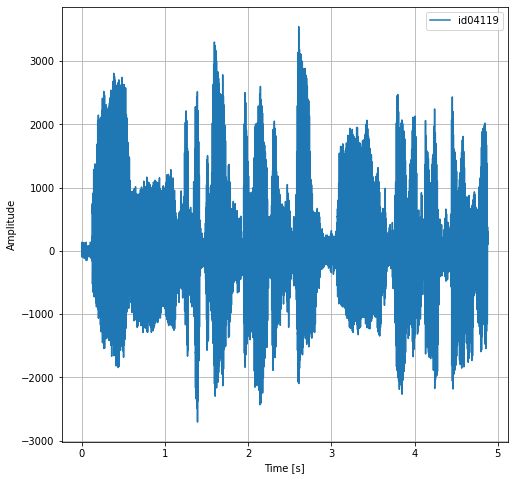

In [3]:
example_file_path = data.File_Path[1]
data_label = data.Labels[1]
samplerate, signal_wav = wavfile.read(example_file_path)

length = signal_wav.shape[0] / samplerate

print(f"length = {length}s")
print(f"sample rate = {samplerate}Hz")

if len(signal_wav.shape) > 1:
    signal_wav = signal_wav[:,0]
time = np.linspace(0., length, signal_wav.shape[0])
plt.plot(time, signal_wav, label=data_label)
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

## Preprocessing
### VAD
We used rVAD: An Unsupervised Segment-Based Robust Voice Activity Detection Method

Repo: https://github.com/zhenghuatan/rVAD

Ref: [https://www.sciencedirect.com/science/article/pii/S0885230819300920]

In [4]:
import sys
sys.path.insert(0, '../rvad')
import rVAD_fast

vad = rVAD_fast.rVAD_fast(example_file_path)

In [5]:
vad_length = len(vad)
print(vad_length)

486


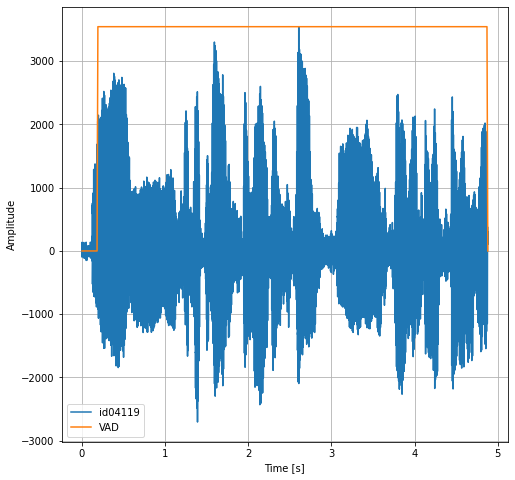

In [6]:
time = np.linspace(0., length, signal_wav.shape[0])
time2 = np.linspace(0., length, vad_length)

plt.plot(time, signal_wav, label=data_label)
plt.plot(time2, vad*max(signal_wav), label = "VAD")
plt.legend()
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.show()

#### Cutting signal with VAD result after LPF


##### LPF
We have a real signal, nyquist freq = 44khz, this is way more than we need since the human voice freq range is 80Hz-255Hz. We will perform a low pass filtering with cut-off frequency 1kHz, (about the same scale and much easier remembering, also the lpf is not ideal and we don't want to cause a signal loss.
Then, we can discard freq > 1k and focus only on relevant signal.


In [7]:
from scipy.signal import butter,filtfilt
def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = fs / 2
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

order = 3
cutoff = 1000
signal_wav_filtered = butter_lowpass_filter(signal_wav, cutoff, samplerate, order)

##### VAD Cutting


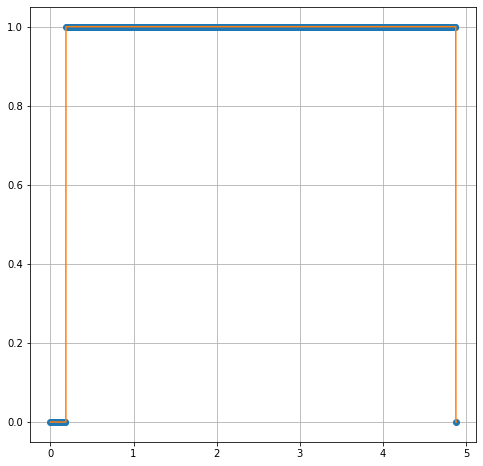

In [8]:
from scipy import interpolate
x = time2
y = vad
f = interpolate.interp1d(x, y,kind='nearest')
xnew = time
ynew = f(time)   # use interpolation function returned by `nearest`
plt.plot(x, y, 'o', xnew, ynew, '-')
plt.show()

In [9]:
signal_wav_after_vad = signal_wav_filtered[np.where(ynew>0)]

## VAD Demo

In [10]:
import scipy
scipy.io.wavfile.write("before_vad.wav", samplerate, signal_wav)
scipy.io.wavfile.write("vad.wav", samplerate, signal_wav[np.where(ynew>0)])
!open before_vad.wav
!sleep 5
!open vad.wav

## Spectrogram

/var/folders/_q/y1_r6q4d4w1cm8nj4hvnxmzc0000gn/T/ipykernel_79912/3382916026.py:3: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.pcolormesh(t, f, Sxx)


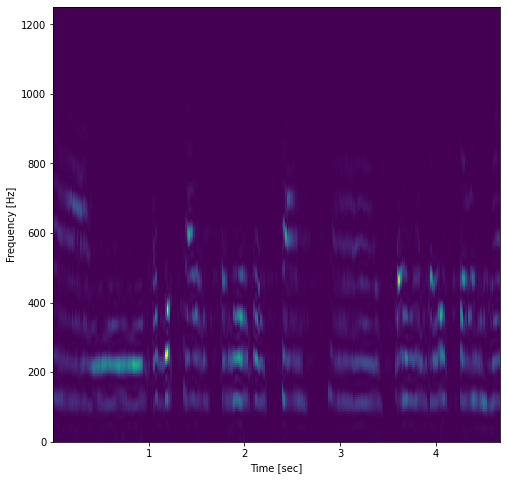

In [18]:
from scipy import signal
f, t, Sxx = signal.spectrogram(signal_wav_after_vad, samplerate, nfft = 8092, nperseg=1024, noverlap=256)
plt.pcolormesh(t, f, Sxx)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim(0, 1250)
plt.show()

## Saving as jpeg
Since we want to save only relevant frequencies (we said roughly ~1k) on 160x160 image we will make sure the final 159 freq is around 1000Hz.
Also, we will resize the x axe to 160 pixels

In [12]:
print("last freq to save == {}".format(f[159]))
assert(f[159]> 800 and f[159] < 1200)


last freq to save == 866.522491349481


In [13]:
Sxx_to_save = Sxx[:160, :]

In [14]:
image_resize_shape = [160,160]
Sxx_to_save = resize(Sxx_to_save, image_resize_shape, anti_aliasing=True)

Lossy conversion from float64 to uint8. Range [0.00039300448741386217, 14291.015924313322]. Convert image to uint8 prior to saving to suppress this warning.


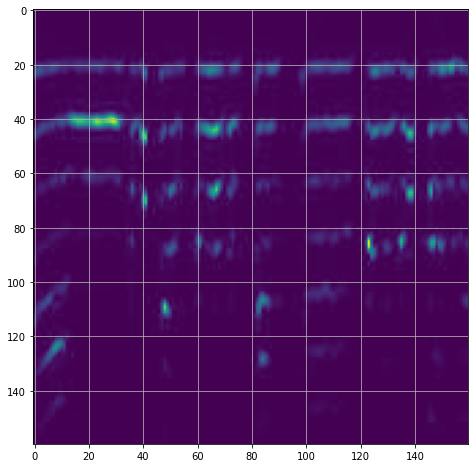

In [15]:
imsave('example_spectrogram.jpeg', Sxx_to_save)
bla = imread('example_spectrogram.jpeg')
plt.imshow(bla)

In [16]:
!ls -lh example_spectrogram.jpeg
!ls -lh vad.wav
!open example_spectrogram.jpeg

-rw-r--r--@ 1 galro  staff   2.5K Jul  6 17:05 example_spectrogram.jpeg
-rw-r--r--@ 1 galro  staff   404K Jul  6 17:05 vad.wav


## Conclusion
Thanks to vad + spectrogram methods we achieved ~200 fold improvement in the data size. Actually we have some compressed representation (lossy one, but still) of our audio data in the jpeg format.

In the next section